In [148]:
from src.cluster_description import Cluster, ClustersDescription
import pyranges as pr
import numpy as np

_GMT_PATH = "./data/c5.go.bp.v7.5.1.entrez.gmt"
_FANTOM_PATH = "./data/FANTOM5_CAGE_peak_entrez_gene_tbl.tsv"

# Parses the GMT file returining a dict containing for each 
# Returns a dictionary mapping each gene entrez id to the ontology group it belongs to.
def parse_gmt(path: str) -> dict[str, list[str]]:
    # Create a dictionary to store the results
    results = {}

    # Open the GMT file
    with open(path, "r") as f:
        # For each line in the file
        for line in f:
            # Split the line into a list of words
            words = line.split("\t")

            # The motif name
            gene_set = words[0]
            link = words[1]
            genes = words[2:]
            # strip each gene
            genes = [gene.strip() for gene in genes]

            # Add the gene set to the dictionary
            results[gene_set] = [link, genes]

    # invert the dictionary
    gmt_inverse : dict[str, list[str]] = {}

    # For each gene set
    for gene_set, (link, genes) in results.items():
        for gene in genes:
            if gene not in gmt_inverse:
                gmt_inverse[gene] = []
            gmt_inverse[gene].append(gene_set)
        
    return gmt_inverse, list(results.keys())

# read the table from the path
def parse_fantom_data(path: str) -> dict[str, str]:
    # Create a dictionary to store the results
    results: dict[str, str] = {}

    header_found = False

    # Open the file
    with open(path, "r") as f:
        # For each line in the file
        for line in f:
            # Go to the next line if it starts with a #
            if line.startswith("#"):
                continue

            # deal with the header
            if not header_found:
                header_found = True
                continue

            # Split the line into a list of words
            words = line.split("\t")
            cage_id = words[0].strip()
            entrez_id = words[1].strip()

            # Add the gene to the dictionary
            results[cage_id] = entrez_id
        
    # Return the results
    return results

# Maps the given entry id to the gene entrez id
def overlaps_to_entrez(overlaps: list[str], peak_to_entrez : dict[str, str]) -> list[str]:
    entrez_ids = []
    for overlap in overlaps:
        entrez_ids.append(peak_to_entrez.get(overlap, None))
    
    # Remove duplicates and NAs
    entrez_ids = [entrez_id for entrez_id in entrez_ids if entrez_id not in ["NA", None]]
    return entrez_ids

# Return the ontology group to which each entrez id belongs to.
def map_entrez_to_ontology(entrez_ids: list[str], gene_ontology : dict[str, str]) -> list[str]:
    ontology_hist = {}
    unknown_entrez_ids = []
    for entrez_id in entrez_ids:
        if entrez_id not in gene_ontology:
            unknown_entrez_ids.append(entrez_id)
            continue
        ontology_groups = gene_ontology[entrez_id]

        for ontology_group in ontology_groups:
            if ontology_group not in ontology_hist:
                ontology_hist[ontology_group] = 0
            ontology_hist[ontology_group] += 1
    
    return ontology_hist, unknown_entrez_ids


def get_groups_for_features(features: list[str], peak_to_entrez: dict[str, str], gene_ontology : dict[str, str]) -> dict[str, int]:
    # Get the entrez ids
    entrez_ids = overlaps_to_entrez(features, peak_to_entrez)

    # Removing duplicates
    entrez_ids = list(set(entrez_ids))
        
    # Get the ontology
    groups, _ = map_entrez_to_ontology(entrez_ids, gene_ontology)
    
    # Return the groups
    return groups, len(entrez_ids)

# Reading the data.
peak_to_entrez = parse_fantom_data(_FANTOM_PATH)
gene_ontology, gene_sets = parse_gmt(_GMT_PATH)

### Getting the Background Data.
The expression of genes is 

In [152]:
# Getting the background
background = pr.read_bed(f"../data/features/HMEC/CAGE/features.bed")

# Getting the representation 
feature_names = background.Name.values.flatten()
expected_groups, population_size = get_groups_for_features(feature_names, peak_to_entrez, gene_ontology)

### Reading the Observed Data

In [153]:
# Read the information about the cluster enriched in both
ENRICHED_IN_BOTH_PATH = "../results/intersected.tsv"

def parse_enrichment_file(path : str):
    results = {}

    with open(path, "r") as f:
        for line in f:
            words = line.split("\t")
            chromosome = words[0].strip()
            clusters = [w.strip() for w in words[1:]]

            results[chromosome] = clusters

    return results

enriched_clusters = parse_enrichment_file(ENRICHED_IN_BOTH_PATH)

In [135]:
# Reading the features.
features = pr.read_bed("../data/features/HMEC/CAGE/features.bed")

observed_genes = []

for chromo, clusters_names in enriched_clusters.items():
    # Reading the clusters.
    clusters = ClustersDescription(f"../data/clusters/HMEC/{chromo}_spec_res.json", chromo)
    
    # Looping over the cluster (strings)
    for cluster in clusters_names:

        # Getting the actual cluster object
        cluster = clusters[cluster]

        # Counting the overlaps
        overlaps = cluster.find_overlaps(chromo, features)
        overlaps_names = overlaps.Name.values.flatten()
        
        # Getting the observed genes
        observed_genes.extend(overlaps_to_entrez(overlaps_names, peak_to_entrez))

        # removing duplicates
        observed_genes = list(set(observed_genes))

observed_groups, _ = map_entrez_to_ontology(observed_genes, gene_ontology)

In [170]:
from scipy.stats import hypergeom

# The p_values
p_values = {}

for _set in gene_sets:
    # run the hypergeometric test
    M = population_size # population size
    n = expected_groups.get(_set, 0) # number of successes in the population
    N = len(observed_genes) # size of the sample
    x = observed_groups.get(_set, 0) # number of successes in the sample

    p_value = hypergeom.sf(x-1, M, n, N)
    p_values[_set] = [p_value, x, n]

In [171]:
# Convert the values to a dataframe
import pandas as pd
p_values_df = pd.DataFrame(p_values).T 

In [173]:
# Add the column names
p_values_df.columns = ["p_value", "observed", "expected"]

In [175]:
M, N

(14140, 959)

In [176]:
p_values_df

,p_value,observed,expected
GOBP_MITOCHONDRIAL_GENOME_MAINTENANCE,0.771436,1.0,21.0
GOBP_REPRODUCTION,0.751646,62.0,984.0
GOBP_SINGLE_STRAND_BREAK_REPAIR,0.144052,2.0,10.0
GOBP_REGULATION_OF_DNA_RECOMBINATION,0.482467,8.0,111.0
GOBP_REGULATION_OF_MITOTIC_RECOMBINATION,0.040042,2.0,5.0
...,...,...,...
GOBP_REGULATION_OF_UNSATURATED_FATTY_ACID_BIOSYNTHETIC_PROCESS,1.000000,0.0,8.0
GOBP_POSITIVE_REGULATION_OF_UNSATURATED_FATTY_ACID_BIOSYNTHETIC_PROCESS,1.000000,0.0,5.0
GOBP_REGULATION_OF_CAVEOLIN_MEDIATED_ENDOCYTOSIS,1.000000,0.0,5.0
GOBP_MALONYL_COA_METABOLIC_PROCESS,0.343915,1.0,6.0


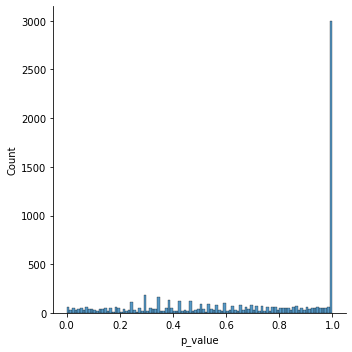

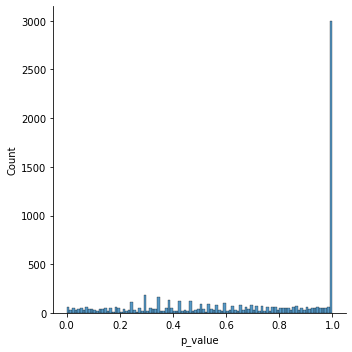

In [181]:
# apply fdr correction
import statsmodels.stats.multitest as smm

p_values_df["q_value"] = smm.multipletests(p_values_df["p_value"], method="fdr_bh")[1]